This document focuses on analyzing the results and presenting the diagrams for the network model.     
The network model contains two intersections consisting of one east-west road and two north-south roads together.    
as control variables to reduce the pressure on the program to run and increase the efficiency of the algorithm. In this model, all roads will be considered for one-way traffic only.   


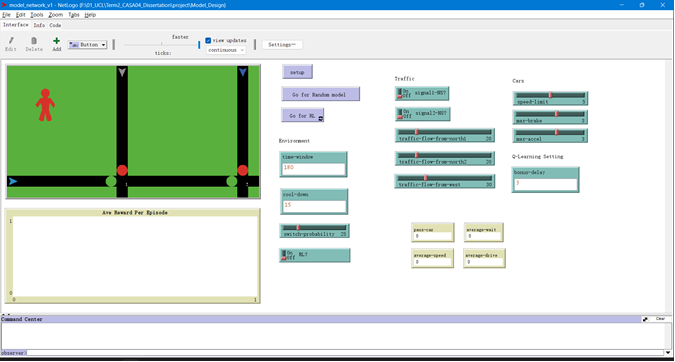

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

## Functions

In [56]:
def getTrend(df_bd):
    # List of columns to plot
    columns_to_plot = ['avg_reward', 'pass_car', 'average_speed', 'average_wait', 'average_drive']

    # Plot each column separately
    plt.figure(figsize=(12, 10))

    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(5, 1, i)
        plt.scatter(df_bd.index, df_bd[column], marker='o',s=1)
        plt.xlabel('step')
        plt.ylabel(column)
        plt.title(f'{column} trend during training')
        plt.grid(True, linestyle='--')
        # Fit a linear regression line
        z = np.polyfit(df_bd.index, df_bd[column], 5)
        p = np.poly1d(z)
        plt.plot(df_bd.index, p(df_bd.index), color='red')


    plt.tight_layout()
    plt.show()

In [44]:
def readBD_CSV(filepath):

    # Define a mapping of current column names to standardized column names
    column_mapping = {
        '[run number]': 'run_number',
        'cool-down': 'cool_down',
        'traffic-flow-from-west': 'traffic_flow_from_west',
        'max-accel': 'max_accel',
        'bonus-delay': 'bonus_delay',
        'traffic-flow-from-north1': 'traffic_flow_from_north1',
        'traffic-flow-from-north2': 'traffic_flow_from_north2',
        'time-window': 'time_window',
        'signal2-NS?': 'signal2_NS',
        'switch-probability': 'switch_probability',
        'speed-limit': 'speed_limit',
        'max-brake': 'max_brake',
        'signal1-NS?': 'signal1_NS',
        'RL?': 'RL',
        '[step]': 'step',
        'time': 'time',
        'pass-car': 'pass_car',
        'avg_reward': 'avg_reward',
        'average-speed': 'average_speed',
        'average-wait': 'average_wait',
        'average-drive': 'average_drive'
    }

    df = pd.read_csv(filepath)
    df.rename(columns=column_mapping, inplace=True)

    # Extract the specified columns and create a new DataFrame
    selected_columns = ['step', 'time', 'pass_car', 'avg_reward', 'average_speed', 'average_wait', 'average_drive']
    df = df[selected_columns]

    # Sort the new DataFrame by the 'step' column in ascending order
    df.sort_values(by='step', inplace=True)

    # Filter rows where 'step' column is divisible by 180
    df = df[df['step'] % 180 == 0]
    df = df[1:]

    # Recompute the DataFrame index
    df.reset_index(drop=True, inplace=True)


    return df

In [59]:
def getAnalysis(df):
    # Select the last 1000 records
    last_1000_records = df.tail(1000)

    # Calculate statistics for each column
    pass_car_stats = {
        'max': last_1000_records['pass_car'].max(),
        'min': last_1000_records['pass_car'].min(),
        'mean': last_1000_records['pass_car'].mean(),
        'std': last_1000_records['pass_car'].std()
    }

    avg_reward_stats = {
        'max': last_1000_records['avg_reward'].max(),
        'min': last_1000_records['avg_reward'].min(),
        'mean': last_1000_records['avg_reward'].mean(),
        'std': last_1000_records['avg_reward'].std()
    }

    average_speed_stats = {
        'max': last_1000_records['average_speed'].max(),
        'min': last_1000_records['average_speed'].min(),
        'mean': last_1000_records['average_speed'].mean(),
        'std': last_1000_records['average_speed'].std()
    }

    average_wait_stats = {
        'max': last_1000_records['average_wait'].max(),
        'min': last_1000_records['average_wait'].min(),
        'mean': last_1000_records['average_wait'].mean(),
        'std': last_1000_records['average_wait'].std()
    }

    average_drive_stats = {
        'max': last_1000_records['average_drive'].max(),
        'min': last_1000_records['average_drive'].min(),
        'mean': last_1000_records['average_drive'].mean(),
        'std': last_1000_records['average_drive'].std()
    }

    # Print the calculated statistics
    print("avg_reward -", avg_reward_stats)
    print("pass_car -", pass_car_stats)
    print("average_speed -", average_speed_stats)
    print("average_wait -", average_wait_stats)
    print("average_drive -", average_drive_stats)

    
    # List of columns to plot
    columns_to_plot = [ 'avg_reward', 'pass_car','average_speed', 'average_wait', 'average_drive']

    # Plot the box plots
    plt.figure(figsize=(12, 6))

    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(1, 5, i)
        plt.boxplot(last_1000_records[column])
        plt.xlabel(column)
        plt.ylabel('Values')
        plt.title(f'Box Plot for {column}')
        plt.grid(True, axis='y', linestyle='--')

        # Calculate statistics for each column
        column_max = last_1000_records[column].max()
        column_min = last_1000_records[column].min()
        column_mean = last_1000_records[column].mean()

        # Add text annotations for mean, max, and min values
        plt.text(1, column_mean, f"Mean: {column_mean:.2f}", ha='center', va='bottom', color='red')
        plt.text(1, column_max, f"Max: {column_max}", ha='center', va='bottom', color='blue')
        plt.text(1, column_min, f"Min: {column_min}", ha='center', va='top', color='green')

    plt.tight_layout()
    plt.show()

## Pre-define model

In this mode, Traffic Lights 1 and 2 will have a 15ticks toggle cooldown, with a 25% probability of toggling the traffic light state every tick while it is toggleable.

In [2]:
# Define a mapping of current column names to standardized column names
column_mapping = {
    '[run number]': 'run_number',
    'cool-down': 'cool_down',
    'traffic-flow-from-west': 'traffic_flow_from_west',
    'max-accel': 'max_accel',
    'bonus-delay': 'bonus_delay',
    'traffic-flow-from-north1': 'traffic_flow_from_north1',
    'traffic-flow-from-north2': 'traffic_flow_from_north2',
    'time-window': 'time_window',
    'signal2-NS?': 'signal2_NS',
    'switch-probability': 'switch_probability',
    'speed-limit': 'speed_limit',
    'max-brake': 'max_brake',
    'signal1-NS?': 'signal1_NS',
    'RL?': 'RL',
    '[step]': 'step',
    'pass-car': 'pass_car',
    'average-speed': 'average_speed',
    'average-wait': 'average_wait',
    'average-drive': 'average_drive'
}

csv_pre = pd.read_csv("./model/network_data_predefine.csv")
# Rename the columns using the mapping
csv_pre.rename(columns=column_mapping, inplace=True)
csv_pre.info()
csv_pre.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   run_number                10001 non-null  int64  
 1   cool_down                 10001 non-null  int64  
 2   traffic_flow_from_west    10001 non-null  int64  
 3   max_accel                 10001 non-null  int64  
 4   bonus_delay               10001 non-null  int64  
 5   traffic_flow_from_north1  10001 non-null  int64  
 6   traffic_flow_from_north2  10001 non-null  int64  
 7   time_window               10001 non-null  int64  
 8   signal2_NS                10001 non-null  bool   
 9   switch_probability        10001 non-null  int64  
 10  speed_limit               10001 non-null  int64  
 11  max_brake                 10001 non-null  int64  
 12  signal1_NS                10001 non-null  bool   
 13  RL                        10001 non-null  bool   
 14  step  

,run_number,cool_down,traffic_flow_from_west,max_accel,bonus_delay,traffic_flow_from_north1,traffic_flow_from_north2,time_window,signal2_NS,switch_probability,speed_limit,max_brake,signal1_NS,RL,step,pass_car,average_speed,average_wait,average_drive
0,1,15,30,3,1,20,20,180,False,25,5,3,False,False,0,0,0.000000,0.000000,0.000000
1,1,15,30,3,1,20,20,180,False,25,5,3,False,False,1,118,2.476345,6.983051,3.525424
2,1,15,30,3,1,20,20,180,False,25,5,3,False,False,2,111,2.272718,9.702703,3.747748
3,1,15,30,3,1,20,20,180,False,25,5,3,False,False,3,115,2.574048,6.652174,3.895652
4,1,15,30,3,1,20,20,180,False,25,5,3,False,False,4,113,1.951802,11.380531,4.203540


In [3]:
# Remove the first row (index 0) from the DataFrame
csv_pre = csv_pre.iloc[1:]

# Calculate mean for each column
mean_pass_car = csv_pre['pass_car'].mean()
mean_average_speed = csv_pre['average_speed'].mean()
mean_average_wait = csv_pre['average_wait'].mean()
mean_average_drive = csv_pre['average_drive'].mean()

# Calculate maximum for each column
max_pass_car = csv_pre['pass_car'].max()
max_average_speed = csv_pre['average_speed'].max()
max_average_wait = csv_pre['average_wait'].max()
max_average_drive = csv_pre['average_drive'].max()

# Calculate minimum for each column
min_pass_car = csv_pre['pass_car'].min()
min_average_speed = csv_pre['average_speed'].min()
min_average_wait = csv_pre['average_wait'].min()
min_average_drive = csv_pre['average_drive'].min()

# Calculate standard deviation for each column
std_pass_car = csv_pre['pass_car'].std()
std_average_speed = csv_pre['average_speed'].std()
std_average_wait = csv_pre['average_wait'].std()
std_average_drive = csv_pre['average_drive'].std()

# Print the results
print("pass_car - Mean:", mean_pass_car, " Max:", max_pass_car, " Min:", min_pass_car, " Std:", std_pass_car)
print("average_speed - Mean:", mean_average_speed, " Max:", max_average_speed, " Min:", min_average_speed, " Std:", std_average_speed)
print("average_wait - Mean:", mean_average_wait, " Max:", max_average_wait, " Min:", min_average_wait, " Std:", std_average_wait)
print("average_drive - Mean:", mean_average_drive, " Max:", max_average_drive, " Min:", min_average_drive, " Std:", std_average_drive)

pass_car - Mean: 114.3083  Max: 154  Min: 84  Std: 8.937585756450973
average_speed - Mean: 2.3617576297718292  Max: 3.1917584692958  Min: 1.521502069929181  Std: 0.22682876134720706
average_wait - Mean: 7.414402705212774  Max: 16.846846846846848  Min: 3.523809523809524  Std: 1.8180180302324405
average_drive - Mean: 3.845246294132511  Max: 4.97196261682243  Min: 3.134020618556701  Std: 0.2118507936173203


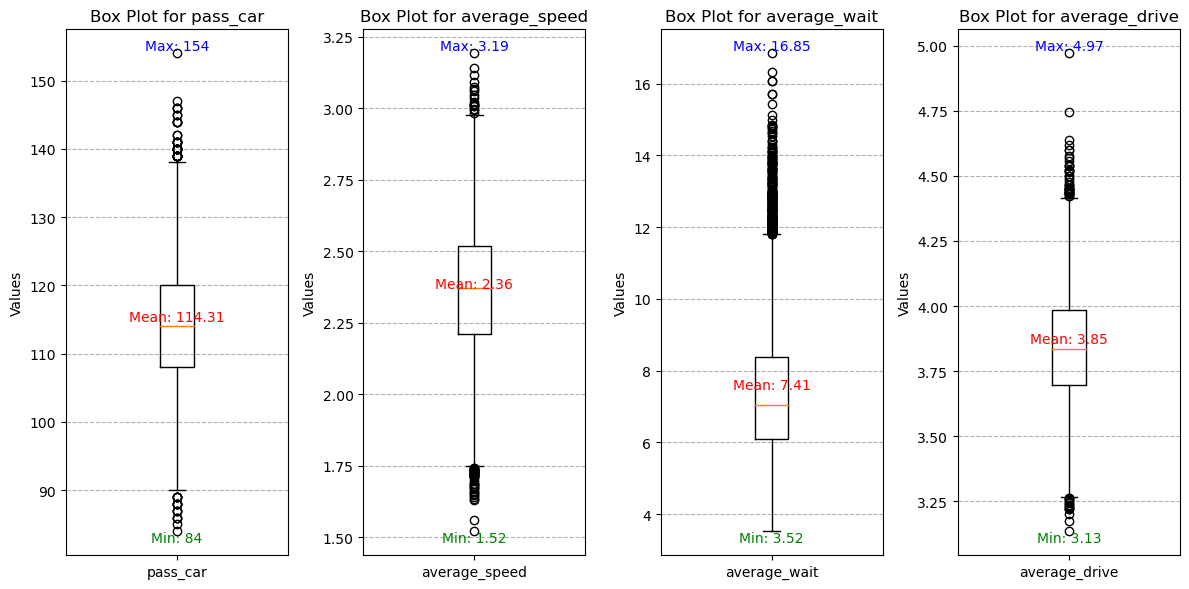

In [40]:
# Convert the specified columns to numeric data types
csv_pre['pass_car'] = pd.to_numeric(csv_pre['pass_car'])
csv_pre['average_speed'] = pd.to_numeric(csv_pre['average_speed'])
csv_pre['average_wait'] = pd.to_numeric(csv_pre['average_wait'])
csv_pre['average_drive'] = pd.to_numeric(csv_pre['average_drive'])

# Calculate the statistics for each column
pass_car_mean = csv_pre['pass_car'].mean()
pass_car_max = csv_pre['pass_car'].max()
pass_car_min = csv_pre['pass_car'].min()

average_speed_mean = csv_pre['average_speed'].mean()
average_speed_max = csv_pre['average_speed'].max()
average_speed_min = csv_pre['average_speed'].min()

average_wait_mean = csv_pre['average_wait'].mean()
average_wait_max = csv_pre['average_wait'].max()
average_wait_min = csv_pre['average_wait'].min()

average_drive_mean = csv_pre['average_drive'].mean()
average_drive_max = csv_pre['average_drive'].max()
average_drive_min = csv_pre['average_drive'].min()

# Plot
plt.figure(figsize=(12, 6))

# Box plot for 'pass_car'
plt.subplot(1, 4, 1)
plt.boxplot(csv_pre['pass_car'])
plt.xticks([1], ['pass_car'])
plt.ylabel('Values')
plt.title('Box Plot for pass_car')
plt.grid(True, axis='y', linestyle='--')
# Display mean value on the 'pass_car' box plot
plt.text(1, pass_car_mean, f"Mean: {pass_car_mean:.2f}", ha='center', va='bottom', color='red')
plt.text(1, pass_car_max, f"Max: {pass_car_max}", ha='center', va='bottom', color='blue')
plt.text(1, pass_car_min, f"Min: {pass_car_min}", ha='center', va='top', color='green')

# Box plots for other columns
columns_to_plot = ['average_speed', 'average_wait', 'average_drive']
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 4, i+1)
    plt.boxplot(csv_pre[column])
    plt.xticks([1], [column])
    plt.ylabel('Values')
    plt.title(f'Box Plot for {column}')
    plt.grid(True, axis='y', linestyle='--')
    # Display mean value on the box plot
    plt.text(1, eval(f"{column}_mean"), f"Mean: {eval(f'{column}_mean'):.2f}", ha='center', va='bottom', color='red')
    plt.text(1, eval(f"{column}_max"), f"Max: {eval(f'{column}_max'):.2f}", ha='center', va='bottom', color='blue')
    plt.text(1, eval(f"{column}_min"), f"Min: {eval(f'{column}_min'):.2f}", ha='center', va='top', color='green')

plt.tight_layout()
plt.show()

## RL

### Bonus Delay 1

In [ ]:
db_1 = readBD_CSV('./model/network_data_RL_BD_1.csv')

avg_reward - {'max': 0.8000801677959242, 'min': 0.2469625374259178, 'mean': 0.521830587058295, 'std': 0.09025545064042645}
pass_car - {'max': 146, 'min': 83, 'mean': 114.789, 'std': 9.533066576834473}
average_speed - {'max': 3.506877087004658, 'min': 1.7064770945703032, 'mean': 2.390647620881262, 'std': 0.24454130924806794}
average_wait - {'max': 20.628865979381445, 'min': 3.2149532710280373, 'mean': 9.376722238044115, 'std': 2.4827065182234835}
average_drive - {'max': 4.660869565217391, 'min': 2.696969696969697, 'mean': 3.762434007825915, 'std': 0.25342584829646125}


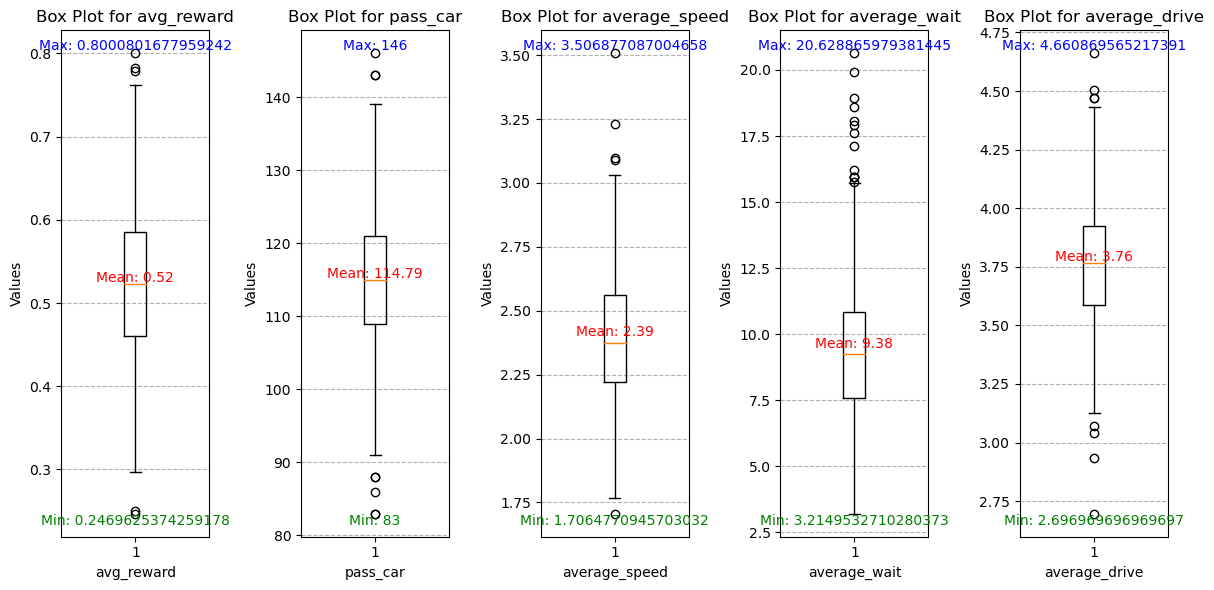

In [60]:
getAnalysis(db_1)

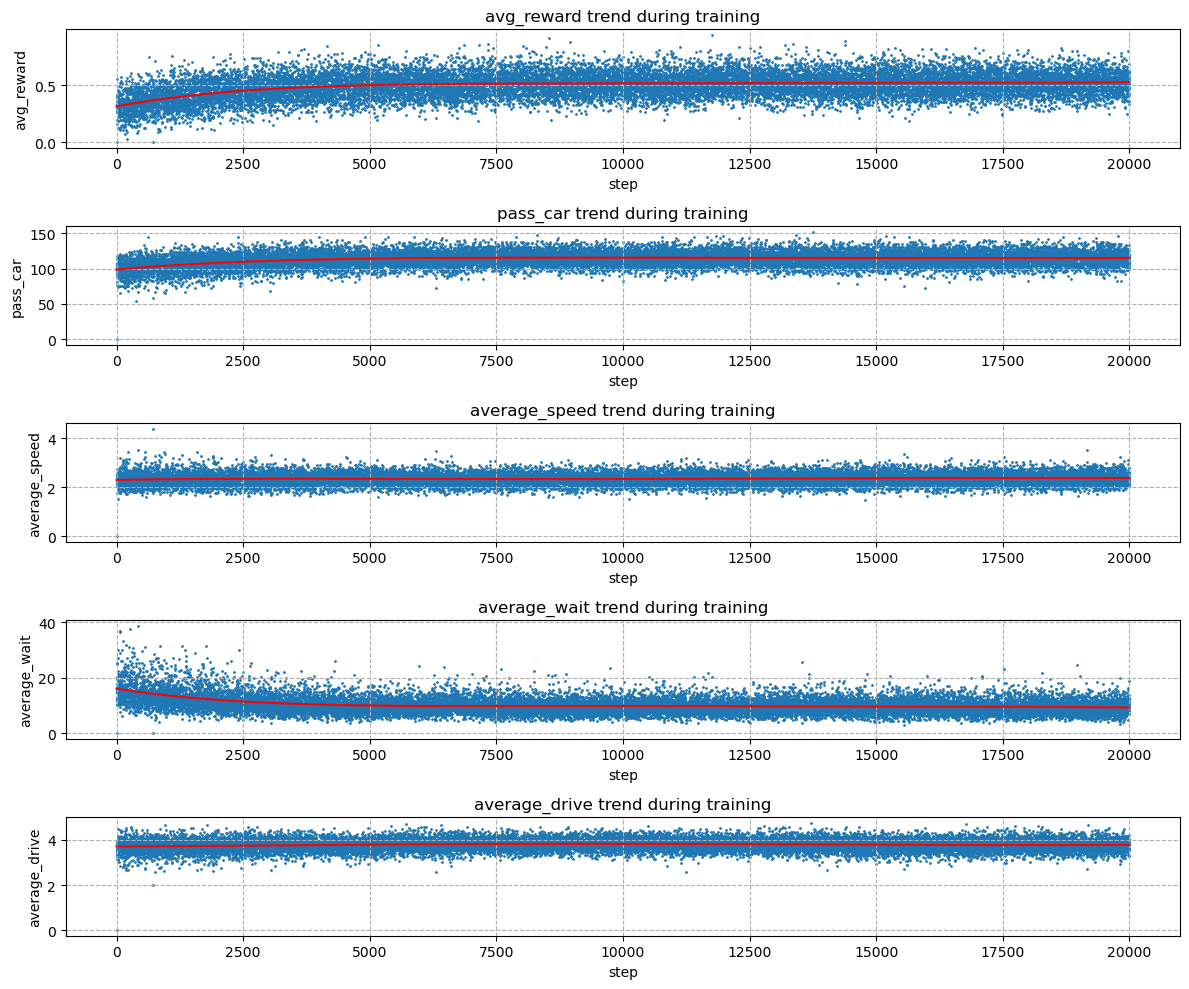

In [61]:
getTrend(db_1)